In [398]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier

In [399]:
data = pd.read_csv("personalized_medication_dataset.csv", sep=";")

# 1 - Descriptive analysis

The dataset consists of 1,000 patient records with 17 variables, covering demographic, medical, and treatment-related information. It includes both numerical attributes such as age, weight, height, BMI, and recovery time, as well as categorical data like gender, chronic conditions, drug allergies, and treatment effectiveness. There are no missing values, and the dataset is clean and well-structured, making it suitable for descriptive and predictive analysis in personalized medication studies.

In [402]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               1000 non-null   object 
 1   Age                      1000 non-null   int64  
 2   Gender                   1000 non-null   object 
 3   Weight_kg                1000 non-null   float64
 4   Height_cm                1000 non-null   float64
 5   BMI                      1000 non-null   float64
 6   Chronic_Conditions       754 non-null    object 
 7   Drug_Allergies           676 non-null    object 
 8   Genetic_Disorders        661 non-null    object 
 9   Diagnosis                1000 non-null   object 
 10  Symptoms                 1000 non-null   object 
 11  Recommended_Medication   737 non-null    object 
 12  Dosage                   805 non-null    object 
 13  Duration                 743 non-null    object 
 14  Treatment_Effectiveness  

In [403]:
data.shape

(1000, 17)

In [404]:
data.head()

,Patient_ID,Age,Gender,Weight_kg,Height_cm,BMI,Chronic_Conditions,Drug_Allergies,Genetic_Disorders,Diagnosis,Symptoms,Recommended_Medication,Dosage,Duration,Treatment_Effectiveness,Adverse_Reactions,Recovery_Time_Days
0,P0001,78,Other,88.7,196.3,21.1,NaN,Penicillin,Cystic Fibrosis,Inflammation,Fever,Amlodipine,NaN,30 days,Effective,Yes,18
1,P0002,57,Female,90.5,195.6,30.2,Hypertension,NaN,Cystic Fibrosis,Depression,"Fatigue, Headache, Dizziness",Amoxicillin,5 mg,NaN,Neutral,No,24
2,P0003,29,Female,87.0,168.2,27.0,NaN,Sulfa,NaN,Inflammation,"Joint Pain, Headache, Nausea",NaN,NaN,7 days,Effective,Yes,12
3,P0004,56,Female,81.4,188.9,26.9,Hypertension,Penicillin,Cystic Fibrosis,Infection,Joint Pain,Ibuprofen,200 mg,7 days,Very Effective,No,22
4,P0005,90,Male,64.2,157.0,33.3,NaN,Sulfa,Sickle Cell Anemia,Inflammation,"Fatigue, Fever, Headache",Amlodipine,500 mg,10 days,Ineffective,Yes,25


In [405]:
data.describe()

,Age,Weight_kg,Height_cm,BMI,Recovery_Time_Days
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.620000,84.337000,175.264800,26.442100,16.272000
std,21.111402,20.403463,14.812709,4.741899,8.108623
min,18.000000,50.000000,150.000000,18.500000,3.000000
25%,34.000000,66.200000,162.575000,22.200000,9.000000
50%,52.000000,84.950000,175.200000,26.200000,16.000000
75%,72.000000,101.650000,188.300000,30.500000,24.000000
max,90.000000,119.800000,199.900000,35.000000,30.000000


In [406]:
data.columns

Index(['Patient_ID', 'Age', 'Gender', 'Weight_kg', 'Height_cm', 'BMI',
       'Chronic_Conditions', 'Drug_Allergies', 'Genetic_Disorders',
       'Diagnosis', 'Symptoms', 'Recommended_Medication', 'Dosage', 'Duration',
       'Treatment_Effectiveness', 'Adverse_Reactions', 'Recovery_Time_Days'],
      dtype='object')

In [407]:
data.isnull().sum()

Patient_ID                   0
Age                          0
Gender                       0
Weight_kg                    0
Height_cm                    0
BMI                          0
Chronic_Conditions         246
Drug_Allergies             324
Genetic_Disorders          339
Diagnosis                    0
Symptoms                     0
Recommended_Medication     263
Dosage                     195
Duration                   257
Treatment_Effectiveness      0
Adverse_Reactions            0
Recovery_Time_Days           0
dtype: int64

In [408]:
data.duplicated().sum()

0

# 2 - Pre-processing

### Unused columns

In [411]:
data = data.drop('Dosage', axis=1)
data = data.drop('Duration', axis=1)
data = data.drop('Treatment_Effectiveness', axis=1)
data = data.drop('Adverse_Reactions', axis=1)
data = data.drop('Recovery_Time_Days', axis=1)
data = data.drop('Patient_ID', axis=1)

In [412]:
data.shape

(1000, 11)

In [413]:
data.head()

,Age,Gender,Weight_kg,Height_cm,BMI,Chronic_Conditions,Drug_Allergies,Genetic_Disorders,Diagnosis,Symptoms,Recommended_Medication
0,78,Other,88.7,196.3,21.1,NaN,Penicillin,Cystic Fibrosis,Inflammation,Fever,Amlodipine
1,57,Female,90.5,195.6,30.2,Hypertension,NaN,Cystic Fibrosis,Depression,"Fatigue, Headache, Dizziness",Amoxicillin
2,29,Female,87.0,168.2,27.0,NaN,Sulfa,NaN,Inflammation,"Joint Pain, Headache, Nausea",NaN
3,56,Female,81.4,188.9,26.9,Hypertension,Penicillin,Cystic Fibrosis,Infection,Joint Pain,Ibuprofen
4,90,Male,64.2,157.0,33.3,NaN,Sulfa,Sickle Cell Anemia,Inflammation,"Fatigue, Fever, Headache",Amlodipine


### NaN

In [415]:
data.isna().sum()

Age                         0
Gender                      0
Weight_kg                   0
Height_cm                   0
BMI                         0
Chronic_Conditions        246
Drug_Allergies            324
Genetic_Disorders         339
Diagnosis                   0
Symptoms                    0
Recommended_Medication    263
dtype: int64

We replaced the NaN values by None for the columns Chronic_Conditions, Drug_Allergies, Genetic_Disorders because those values correspond to the patients having 0 chronic conditions or drug allergies or gentic disorders (different from not having an answer). Similarly for Recommended_Medication we replace the NaN values by Nothing.

In [417]:
data['Chronic_Conditions'] = data['Chronic_Conditions'].fillna('None')
data['Drug_Allergies'] = data['Drug_Allergies'].fillna('None')
data['Genetic_Disorders'] = data['Genetic_Disorders'].fillna('None')
data['Recommended_Medication'] = data['Recommended_Medication'].fillna('Nothing')

In [418]:
data.head()

,Age,Gender,Weight_kg,Height_cm,BMI,Chronic_Conditions,Drug_Allergies,Genetic_Disorders,Diagnosis,Symptoms,Recommended_Medication
0,78,Other,88.7,196.3,21.1,None,Penicillin,Cystic Fibrosis,Inflammation,Fever,Amlodipine
1,57,Female,90.5,195.6,30.2,Hypertension,None,Cystic Fibrosis,Depression,"Fatigue, Headache, Dizziness",Amoxicillin
2,29,Female,87.0,168.2,27.0,None,Sulfa,None,Inflammation,"Joint Pain, Headache, Nausea",Nothing
3,56,Female,81.4,188.9,26.9,Hypertension,Penicillin,Cystic Fibrosis,Infection,Joint Pain,Ibuprofen
4,90,Male,64.2,157.0,33.3,None,Sulfa,Sickle Cell Anemia,Inflammation,"Fatigue, Fever, Headache",Amlodipine


In [419]:
data.isna().sum()

Age                       0
Gender                    0
Weight_kg                 0
Height_cm                 0
BMI                       0
Chronic_Conditions        0
Drug_Allergies            0
Genetic_Disorders         0
Diagnosis                 0
Symptoms                  0
Recommended_Medication    0
dtype: int64

### Non numerical columns

In [421]:
le = LabelEncoder()

Gender

In [423]:
data.Gender.unique()

array(['Other', 'Female', 'Male'], dtype=object)

In [424]:
data['Gender'] = le.fit_transform(data['Gender'])

In [425]:
data.head()

,Age,Gender,Weight_kg,Height_cm,BMI,Chronic_Conditions,Drug_Allergies,Genetic_Disorders,Diagnosis,Symptoms,Recommended_Medication
0,78,2,88.7,196.3,21.1,None,Penicillin,Cystic Fibrosis,Inflammation,Fever,Amlodipine
1,57,0,90.5,195.6,30.2,Hypertension,None,Cystic Fibrosis,Depression,"Fatigue, Headache, Dizziness",Amoxicillin
2,29,0,87.0,168.2,27.0,None,Sulfa,None,Inflammation,"Joint Pain, Headache, Nausea",Nothing
3,56,0,81.4,188.9,26.9,Hypertension,Penicillin,Cystic Fibrosis,Infection,Joint Pain,Ibuprofen
4,90,1,64.2,157.0,33.3,None,Sulfa,Sickle Cell Anemia,Inflammation,"Fatigue, Fever, Headache",Amlodipine


Chronic_Conditions

In [427]:
data.Chronic_Conditions.unique()

array(['None', 'Hypertension', 'Asthma', 'Diabetes'], dtype=object)

In [428]:
data['Chronic_Conditions'] = le.fit_transform(data['Chronic_Conditions'])

Drug_Allergies

In [430]:
data.Drug_Allergies.unique()

array(['Penicillin', 'None', 'Sulfa'], dtype=object)

In [431]:
data['Drug_Allergies'] = le.fit_transform(data['Drug_Allergies'])

Genetic_Disorders

In [433]:
data.Genetic_Disorders.unique()

array(['Cystic Fibrosis', 'None', 'Sickle Cell Anemia'], dtype=object)

In [434]:
data['Genetic_Disorders'] = le.fit_transform(data['Genetic_Disorders'])

Diagnosis	

In [436]:
data.Diagnosis.unique()

array(['Inflammation', 'Depression', 'Infection', 'Arthritis',
       'Hypertension'], dtype=object)

In [437]:
data['Diagnosis'] = le.fit_transform(data['Diagnosis'])

Recommended_Medication

In [439]:
data.Recommended_Medication.unique()

array(['Amlodipine', 'Amoxicillin', 'Nothing', 'Ibuprofen'], dtype=object)

In [440]:
data['Recommended_Medication'] = le.fit_transform(data['Recommended_Medication'])

Symptoms

In [442]:
data.Symptoms.unique()

array(['Fever', 'Fatigue, Headache, Dizziness',
       'Joint Pain, Headache, Nausea', 'Joint Pain',
       'Fatigue, Fever, Headache', 'Cough', 'Nausea, Fatigue',
       'Fatigue, Dizziness', 'Joint Pain, Dizziness, Fever',
       'Cough, Joint Pain, Dizziness', 'Joint Pain, Nausea',
       'Cough, Fever', 'Fever, Joint Pain, Dizziness',
       'Dizziness, Nausea', 'Joint Pain, Cough', 'Cough, Joint Pain',
       'Fever, Fatigue', 'Nausea', 'Headache, Dizziness', 'Cough, Nausea',
       'Dizziness, Headache, Joint Pain', 'Nausea, Headache',
       'Fatigue, Cough, Headache', 'Fatigue, Joint Pain',
       'Joint Pain, Dizziness', 'Joint Pain, Fatigue', 'Headache',
       'Dizziness', 'Headache, Cough', 'Headache, Nausea',
       'Nausea, Joint Pain', 'Fatigue, Dizziness, Nausea',
       'Dizziness, Headache', 'Nausea, Dizziness', 'Nausea, Fever, Cough',
       'Dizziness, Fever', 'Fatigue, Nausea, Cough', 'Fatigue',
       'Cough, Dizziness, Fever', 'Fever, Headache',
       'Headache,

As there are many possible combinations of symptoms, we decided to create 7 separate columns, each representing one of the 7 possible symptoms.

In [444]:
data['Symptoms_list'] = data['Symptoms'].str.split(', ')
data_s = data['Symptoms_list'].str.join('|').str.get_dummies()
data = data.join(data_s)
data = data.drop("Symptoms_list", axis=1)
data = data.drop("Symptoms", axis=1)

In [445]:
data.head()

,Age,Gender,Weight_kg,Height_cm,BMI,Chronic_Conditions,Drug_Allergies,Genetic_Disorders,Diagnosis,Recommended_Medication,Cough,Dizziness,Fatigue,Fever,Headache,Joint Pain,Nausea
0,78,2,88.7,196.3,21.1,3,1,0,4,0,0,0,0,1,0,0,0
1,57,0,90.5,195.6,30.2,2,0,0,1,1,0,1,1,0,1,0,0
2,29,0,87.0,168.2,27.0,3,2,1,4,3,0,0,0,0,1,1,1
3,56,0,81.4,188.9,26.9,2,1,0,3,2,0,0,0,0,0,1,0
4,90,1,64.2,157.0,33.3,3,2,2,4,0,0,0,1,1,1,0,0


In [446]:
corr = data.corr()['Recommended_Medication'].sort_values(ascending=False)
print(corr)

Recommended_Medication    1.000000
Dizziness                 0.049471
Gender                    0.048198
Genetic_Disorders         0.030934
Nausea                    0.022751
Fever                     0.022151
Diagnosis                 0.010961
Fatigue                   0.008888
Age                       0.001189
BMI                      -0.000666
Cough                    -0.006702
Headache                 -0.008059
Joint Pain               -0.012226
Chronic_Conditions       -0.040227
Drug_Allergies           -0.055043
Height_cm                -0.076106
Weight_kg                -0.079978
Name: Recommended_Medication, dtype: float64


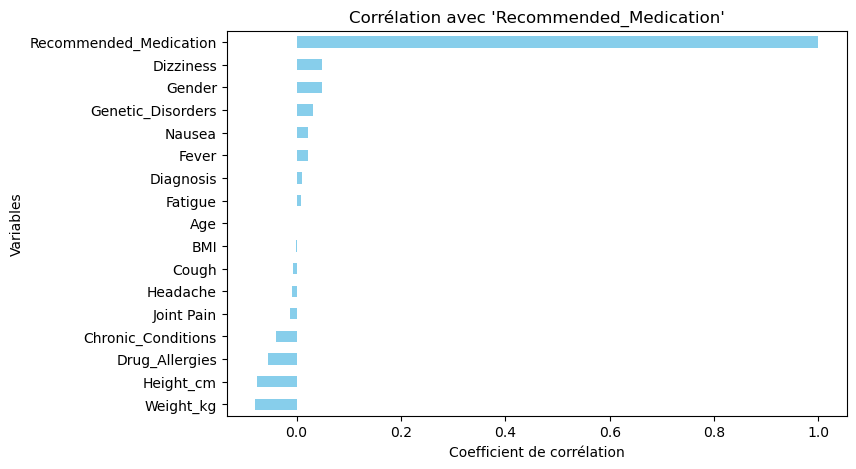

In [447]:
corr = data.corr()['Recommended_Medication'].sort_values(ascending=False)

plt.figure(figsize=(8,5))
corr.plot(kind='barh', color='skyblue')
plt.title("Corrélation avec 'Recommended_Medication'")
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Variables")
plt.gca().invert_yaxis() 
plt.show()

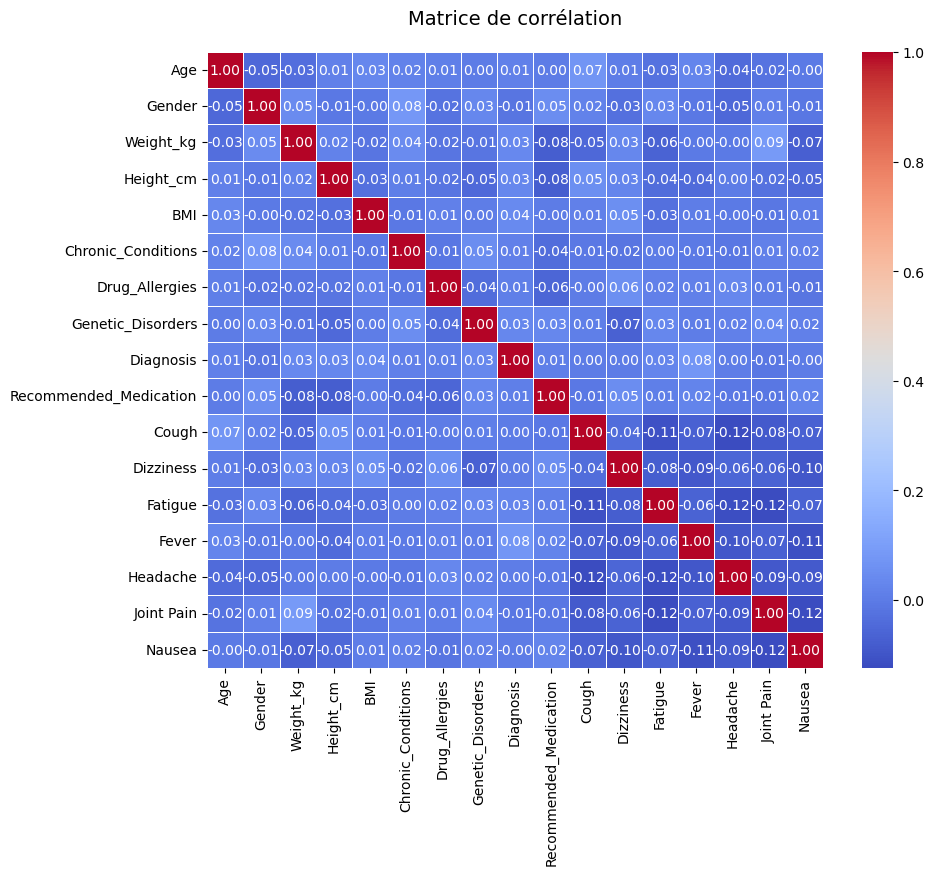

In [448]:
corr = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)    

plt.title("Matrice de corrélation", fontsize=14, pad=20)
plt.show()

# 3. Formalization of the problem

We’re doing a prediction of the recommended medication a patient should take considering information about him (symptoms,age, gender,allergies…).  It’s a multiclass classification problem. 

input (X) = patient features 

output (y) = recommended medication (amlodipine, ibuprofen, amoxicillin, none) 

# 4. Implementation of the model

We’re using a supervised model. Since our task is a multiclass classification problem (predicting the recommended medication from patient characteristics), we selected a Decision Tree Classifier as our baseline model. This model provides interpretability through decision rules and feature importance, which is valuable in a medical context. Performance from this model will serve as our baseline for evaluating more advanced models such as Random Forests. 

Accuracy du modèle : 0.23


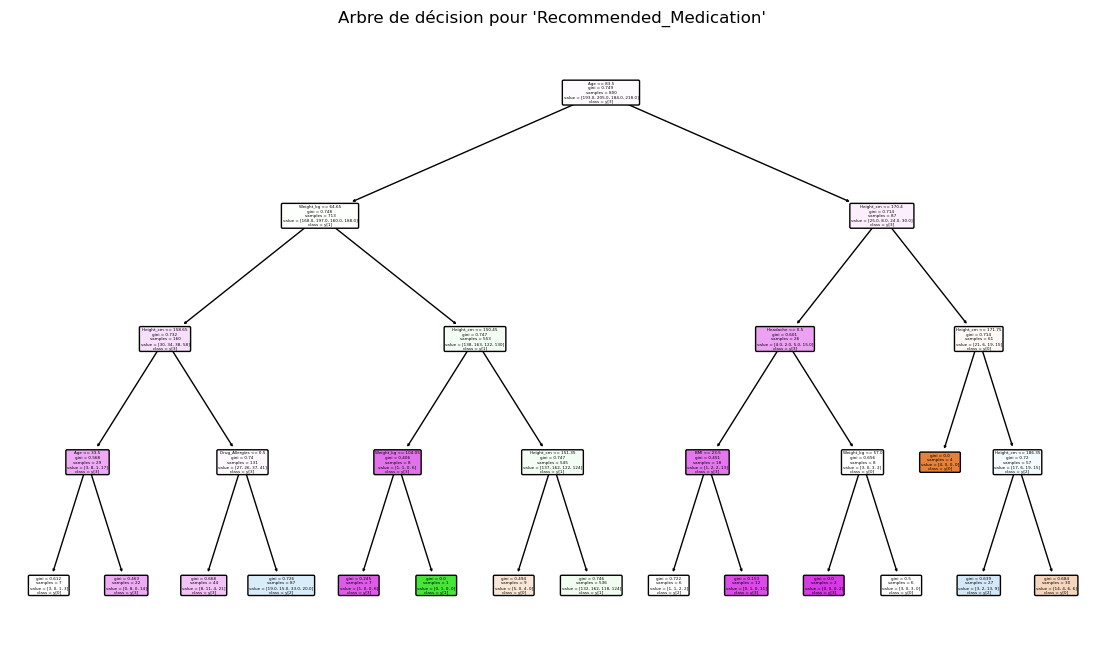

In [453]:
if data['Recommended_Medication'].dtype == 'object':
    data['Recommended_Medication'] = data['Recommended_Medication'].astype('category').cat.codes

X = data.drop('Recommended_Medication', axis=1)
y = data['Recommended_Medication']

X = X.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42, max_depth=4)  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")

plt.figure(figsize=(14, 8))
plot_tree(model, feature_names=X.columns, class_names=True, filled=True, rounded=True)
plt.title("Arbre de décision pour 'Recommended_Medication'")
plt.show()

In [454]:
params_dt = {'criterion': ['gini', 'entropy'],'max_depth': [3, 5, 10, None],'min_samples_split': [2, 5, 10]}

grid_dt = GridSearchCV(DecisionTreeClassifier(),params_dt,cv=5,scoring='accuracy')
grid_dt.fit(X_train, y_train)

print("Best params DT:", grid_dt.best_params_)
print("Best accuracy:", grid_dt.best_score_)

Best params DT: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}
Best accuracy: 0.27749999999999997


In [455]:
categorical_cols = ['Gender', 'Symptoms', 'Allergies', 'Genetic_Disorders']
numeric_cols = [col for col in data.columns if data[col].dtype != 'object' and col != 'Recommended_Medication']

preprocess = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),('num', StandardScaler(), numeric_cols)])

In [456]:
data['Recommended_Medication'].value_counts(normalize=True)

Recommended_Medication
3    0.263
1    0.254
0    0.245
2    0.238
Name: proportion, dtype: float64

In [457]:
print(data.dtypes)
print(data.head())

Age                         int64
Gender                      int32
Weight_kg                 float64
Height_cm                 float64
BMI                       float64
Chronic_Conditions          int32
Drug_Allergies              int32
Genetic_Disorders           int32
Diagnosis                   int32
Recommended_Medication      int32
Cough                       int64
Dizziness                   int64
Fatigue                     int64
Fever                       int64
Headache                    int64
Joint Pain                  int64
Nausea                      int64
dtype: object
   Age  Gender  Weight_kg  Height_cm   BMI  Chronic_Conditions  \
0   78       2       88.7      196.3  21.1                   3   
1   57       0       90.5      195.6  30.2                   2   
2   29       0       87.0      168.2  27.0                   3   
3   56       0       81.4      188.9  26.9                   2   
4   90       1       64.2      157.0  33.3                   3   

   Drug_All

In [458]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     1000 non-null   int64  
 1   Gender                  1000 non-null   int32  
 2   Weight_kg               1000 non-null   float64
 3   Height_cm               1000 non-null   float64
 4   BMI                     1000 non-null   float64
 5   Chronic_Conditions      1000 non-null   int32  
 6   Drug_Allergies          1000 non-null   int32  
 7   Genetic_Disorders       1000 non-null   int32  
 8   Diagnosis               1000 non-null   int32  
 9   Recommended_Medication  1000 non-null   int32  
 10  Cough                   1000 non-null   int64  
 11  Dizziness               1000 non-null   int64  
 12  Fatigue                 1000 non-null   int64  
 13  Fever                   1000 non-null   int64  
 14  Headache                1000 non-null   i

In [459]:
print(data['Diagnosis'].value_counts())

Diagnosis
0    218
4    202
1    202
3    194
2    184
Name: count, dtype: int64


In [460]:
print(data.isna().sum())

Age                       0
Gender                    0
Weight_kg                 0
Height_cm                 0
BMI                       0
Chronic_Conditions        0
Drug_Allergies            0
Genetic_Disorders         0
Diagnosis                 0
Recommended_Medication    0
Cough                     0
Dizziness                 0
Fatigue                   0
Fever                     0
Headache                  0
Joint Pain                0
Nausea                    0
dtype: int64


### Random Forest

In [461]:
data = data.drop(columns=["Diagnosis"])

X = data.drop(columns=["Recommended_Medication"])
y = data["Recommended_Medication"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=500,max_depth=None,random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.26


We first removed the diagnosis column because it could leak information directly related to the target. Then, we separated the dataset into features (X) and the target variable (y). Using train_test_split, we created a training set and a test set while keeping the class proportions balanced thanks to stratify=y. Next, we standardized all numerical features with StandardScaler to ensure that the model receives scaled inputs. We then trained a Random Forest classifier with 500 trees and no limit on tree depth. After fitting the model on the training data, we predicted the medication on the test set and evaluated the model’s performance. The accuracy obtained (0.26) indicates that the model correctly predicted 26% of the test samples. 

### Grid Search

In [462]:
params_dt = {'criterion': ['gini', 'entropy', 'log_loss'],'max_depth': [3, 5, 8, 12, 20, None],'min_samples_split': [2, 5, 10, 20],'min_samples_leaf': [1, 2, 4, 10],'max_features': [None, 'sqrt', 'log2']}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),params_dt,cv=5,scoring='accuracy',n_jobs=-1)

grid_dt.fit(X_train, y_train)

print("Best Decision Tree parameters:", grid_dt.best_params_)
print("Best cross-validation accuracy:", grid_dt.best_score_)

y_pred_dt = grid_dt.best_estimator_.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_dt))

Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.26749999999999996
Test accuracy: 0.21


We tried another model, we performed hyperparameter tuning on a Decision Tree using GridSearchCV. First, we defined a set of possible values for several Decision Tree parameters (such as the criterion, max depth, minimum samples to split, and maximum number of features to consider). GridSearchCV then trained multiple models, each using a different combination of these parameters, and evaluated them using 5-fold cross-validation. After testing all combinations, it selected the model with the best accuracy. Finally, the best model was used to make predictions on the test set, and we obtain a test accuracy of 0.21 and a cross-validation accuracy of 0.267. 

### Grid Search + Random Forest

In [463]:
params_rf = {'n_estimators': [200, 500, 800],'max_depth': [None, 10, 20, 30],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4],'max_features': ['auto', 'sqrt', 'log2'],'bootstrap': [True, False]}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),params_rf,cv=5,scoring='accuracy',n_jobs=-1)

grid_rf.fit(X_train, y_train)

print("Best Random Forest parameters:", grid_rf.best_params_)
print("Best cross-validation accuracy:", grid_rf.best_score_)

y_pred_rf = grid_rf.best_estimator_.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_rf))

C:\Users\Nastya\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
317 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nastya\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nastya\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Nastya\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Nastya\anaconda3\Lib\site

Best Random Forest parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Best cross-validation accuracy: 0.25125
Test accuracy: 0.24


We performed hyperparameter tuning on a Random Forest using GridSearchCV. We defined a grid of possible values for important parameters such as the number of trees, maximum depth, minimum samples per split and per leaf, the number of features considered at each split, and whether bootstrap sampling is used. GridSearchCV trained and evaluated all parameter combinations using 5-fold cross-validation to identify the best model. The search returned the configuration with the best cross-validation accuracy (0.25). You then evaluated this optimized model on the test set, obtaining a test accuracy of 0.24, meaning that even after tuning, the Random Forest only slightly improved and still struggled to generalize well on this dataset. 

### XGBoost

In [464]:
xgb_model = XGBClassifier(objective='multi:softmax',num_class=len(y.unique()),eval_metric='mlogloss',learning_rate=0.1,max_depth=6,n_estimators=300,subsample=0.8,colsample_bytree=0.8,random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Test Accuracy: 0.21


We trained an XGBoost classifier configured for multiclass classification using the softmax objective. We specified several key hyperparameters: the learning rate (0.1), tree depth (6), number of boosting rounds (300), and subsampling ratios for rows and features to reduce overfitting. After fitting the model on the training data, we used it to predict the medication on the test set. Finally, we calculated the test accuracy, which reached 0.205, indicating that XGBoost performed worse than the other models on this dataset despite its advanced boosting strategy. 

### Grid Search + XGBoost

In [465]:
params_xgb = {"learning_rate": [0.01, 0.05, 0.1],"max_depth": [4, 6, 8],"n_estimators": [200, 300, 500],"subsample": [0.7, 0.8, 1.0],"colsample_bytree": [0.7, 0.8, 1.0]}

xgb = XGBClassifier(objective="multi:softmax",num_class=len(y.unique()),eval_metric="mlogloss",random_state=42)

grid_xgb = GridSearchCV(xgb,params_xgb,cv=5,scoring="accuracy",n_jobs=-1)

grid_xgb.fit(X_train, y_train)

print("Best XGBoost parameters:", grid_xgb.best_params_)
print("Best CV accuracy:", grid_xgb.best_score_)

y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)
print("XGBoost Test accuracy:", accuracy_score(y_test, y_pred_xgb))

Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Best CV accuracy: 0.25625
XGBoost Test accuracy: 0.265


We applied GridSearchCV to optimize the XGBoost classifier by testing different values for key hyperparameters, including the learning rate, tree depth, number of boosting rounds, and subsampling ratios. GridSearchCV trained multiple XGBoost models using 5-fold cross-validation, evaluating each combination based on accuracy. After exploring the full parameter grid, it selected the configuration that achieved the best cross-validation accuracy (0.2575). We then used this best model to make predictions on the test set, obtaining a test accuracy of 0.25. This shows that hyperparameter tuning improved XGBoost slightly compared to the default version, but its performance remained limited on this dataset. 

### Bagging

In [529]:
X = data.drop(columns=["Recommended_Medication"])
y = data["Recommended_Medication"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=50,random_state=42)

bagging_model.fit(X_train, y_train)

y_pred = bagging_model.predict(X_test)

print("Bagging Accuracy:", accuracy_score(y_test, y_pred))

Bagging Accuracy: 0.225


We split the dataset into training and test sets while preserving class proportions. After scaling the numerical features, we trained a BaggingClassifier using 50 Decision Trees as base estimators. Bagging works by training each tree on a different random subset of the data, which helps reduce variance and improve robustness. After fitting the ensemble on the training data, we used it to predict the medication on the test set and computed the accuracy. The model reached an accuracy of 0.225, showing that bagging provided slightly better performance than a single decision tree but remained limited on this dataset, linked to the complexity of the dataset. 

# 5- The complexity of the dataset

In [467]:
print(data['Recommended_Medication'].value_counts())

Recommended_Medication
3    263
1    254
0    245
2    238
Name: count, dtype: int64


The medication is randomly distributed.

In [468]:
corr = data.corr(numeric_only=True)['Recommended_Medication'].sort_values(ascending=False)
print(corr)

Recommended_Medication    1.000000
Dizziness                 0.049471
Gender                    0.048198
Genetic_Disorders         0.030934
Nausea                    0.022751
Fever                     0.022151
Fatigue                   0.008888
Age                       0.001189
BMI                      -0.000666
Cough                    -0.006702
Headache                 -0.008059
Joint Pain               -0.012226
Chronic_Conditions       -0.040227
Drug_Allergies           -0.055043
Height_cm                -0.076106
Weight_kg                -0.079978
Name: Recommended_Medication, dtype: float64


The data is not correlated.